## Logistic Regression

We saw in the previous lesson how supervised machine learning allows us to build predictive models of linear relationships in our data. What if our data cannot be modeled well by a linear function? For example, we might wish to model the probability of a borrower defaulting on their credit card balance as a function of the size of the balance relative to their income. The dataset for this problem might look like the following:

In [1]:
import numpy as np

balance_as_pct_of_income = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
probability_of_default = np.array([0.05, 0.07, 0.10, 0.15, 0.25, 0.5, 0.75, 0.90, 0.95,0.99])

The problem for us is that this data has a decidely non-linear shape:

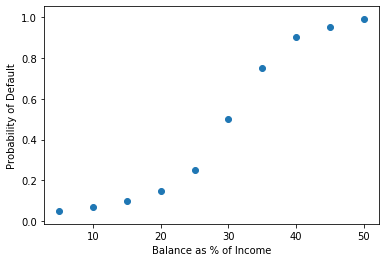

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(balance_as_pct_of_income, probability_of_default)
plt.xlabel('Balance as % of Income')
plt.ylabel('Probability of Default')
plt.show()

The following effects cause the graph to have this distinctive S-shape:

1. The probability of default is relatively insensitive to the balance as long as the balance is well within the range that the customer can pay, so it increases slowly at the beginning. 
2. As the customer approaches the limits of their ability to make payments, the probability of default rises rapidly. 
3. Eventually, the curve starts to bend as we move along the x-axis because the probability can never exceed 1, as that indicates absolute certainty of default.

### Modeling Probabilities with Logistic Curves

When our data looked like a line, we used machine learning to build a linear function to model it. When our data looks like the graph above, what type of function should we build to model it? It turns out that data with the above pattern is modeled well by a **logistic curve**, which is a fuction of the form: 

$$f(x) = \frac{1}{1 + e^{-k(x - x_0)}}$$

Do not worry excessively about the math involved in this definition - the important fact to grasp is that, just as we could adjust the slope and the intercept of our linear model in the linear regression lesson, we can adjust the following parameters of our logistic curve model:

1. The steepness, $k$
2. The midpoint, $x_0$

Let's experiment with different values of these parameters to see if we can come up with a model that can accurately predict our probability values. First, we will vary the midpoint value: 

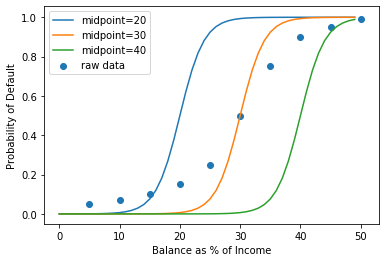

In [3]:
import numpy as np

midpoints = [20,30,40]
steepness = 0.5
x = np.arange(0, 50)
for midpoint in midpoints:
    y = 1/(1 + np.exp(-steepness*(x - midpoint)))
    plt.plot(x,y,label='midpoint=' + str(midpoint))
plt.scatter(balance_as_pct_of_income, probability_of_default, label='raw data')
plt.xlabel('Balance as % of Income')
plt.ylabel('Probability of Default')
plt.legend()
plt.show()

It looks like a value of `30` is the best value for the midpoint. Now let's try to find a good value for the steepness:

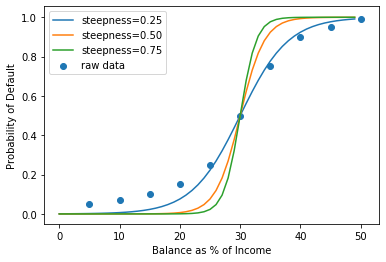

In [4]:
midpoint = 30
steepness_values = [0.25, 0.50, 0.75]
for steepness in steepness_values:
    y = 1/(1 + np.exp(-steepness*(x - midpoint)))
    plt.plot(x,y,label='steepness=' + "{0:.2f}".format(steepness))
plt.scatter(balance_as_pct_of_income, probability_of_default, label='raw data')
plt.xlabel('Balance as % of Income')
plt.ylabel('Probability of Default')
plt.legend()
plt.show()

A steepness value of `0.25` seems very close to correct. So our final guess for the appropriate model parameters is: 

1. Steepness = 0.25
2. Midpoint = 30

### Building Logistic Curves with the Logistic Regression Method

The above process of finding the appropriate model parameters is obviously cumbersome; instead of finding the parameters manually, we can invoke the machine learning method of **logistic regression** to automatically build a logistic curve with the correct parameter values.

Since we are going to build a real machine learning model, let's begin our analysis by using a more realistic dataset. Usually, we will not begin with an array containing *probabilities*, but rather with an array of *individual default events*. So instead of the `probability_of_default` array above, we will start from a larger array containing default data for *individual customers*:

In [5]:
import pandas as pd

raw_default_data_df = pd.read_csv("data/raw_default_data.csv")
raw_default_data_df.head()

,Balance as % of Income,Defaulted? (0/1 = no/yes)
0,5,0
1,30,1
2,45,1
3,20,0
4,15,1


With this data in hand, we can perform logistic regression to obtain a logistic curve model of our data:

In [6]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs')
x = np.array(raw_default_data_df['Balance as % of Income'])
X = x.reshape(-1,1)
y = np.array(raw_default_data_df['Defaulted? (0/1 = no/yes)'])
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Note that we use the keyword argument `solver='lbfgs'` to control *how* the machine learning module builds our model - no matter what solver we use, the *type* of model we get out at the end is always the same: a logistic curve.

Let's see how accurate our new model is by *predicting* our output variable, the probability of default:

In [7]:
predicted_probs = logistic.predict_proba(balance_as_pct_of_income.reshape(-1,1))
predicted_probs

array([[0.98313341, 0.01686659],
       [0.96151194, 0.03848806],
       [0.91458178, 0.08541822],
       [0.82107623, 0.17892377],
       [0.6629358 , 0.3370642 ],
       [0.45739192, 0.54260808],
       [0.26539804, 0.73460196],
       [0.13408075, 0.86591925],
       [0.06223389, 0.93776611],
       [0.0276564 , 0.9723436 ]])

Notice that the array above has two columns: the probability of NOT defaulting, and the probability of defaulting. We want the second column. 

Let's plot our results and see what they look like:

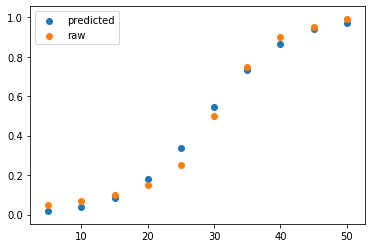

In [9]:
X = balance_as_pct_of_income.reshape(-1,1)
plt.scatter(X, predicted_probs[:,1], label='predicted')
plt.scatter(X, probability_of_default, label='raw')
plt.legend()
plt.show()

Not too bad! How close is this model to the model we came up with through trial and error? The `sklearn` model labels its parameters slightly differently, but some simple math allows us to convert them to steepness and midpoint values:

In [10]:
model_steepness = logistic.coef_[0][0]
model_midpoint = -1 * logistic.intercept_[0]/model_steepness
print(model_steepness)
print(model_midpoint)

0.16945027864782097
28.991759281578272


These values seem reasonable when compared to our manually chosen values above. Based on our graph and our examination of the model parameters, we now know that our training process has produced a qualitatively reasonable machine learning model. We still need to perform a rigorous *quantitative*  assessment of our model's accuracy, but performing this assessment is actually a surprisingly nuanced task - we will therefore defer this process until the next lesson. 

<span style="color:blue;font-weight:bold">Exercise</span>: Predicting Credit Card Default. 

Suppose that the probability of customer defaulting on a particular credit card decreases rapidly with the number of months that they have successfully made prior payments. Intuitively, this makes sense: someone who has been making payments on-time for years is much less likely to miss future payments than someone with no prior history. In this exercise, we will use logistic regression to model the probability of default as a function of the number of months in which the borrower has successfully made their payments. The following $x$ and $y$ values give the relationship between the number of months that the borrower has been in good standing and their probability of default:

In [11]:
months_in_good_standing = np.array([3, 6, 12, 18, 24, 36, 48])
probabilities_by_months = np.array([0.35, 0.33, 0.20, 0.07, 0.03, 0.02, 0.01])

Perform the following tasks:

1. Load the dataset from the file `data/credit_card_exercise.csv` and store it in the DataFrame variable `df`
2. Use this data to construct a logistic regression model with `'Months in Good Standing'` as your $x$ variable and `'Defaulted? (0/1 = no/yes)'` as your $y$ variable - you must store this model in the variable `logistic`, and pass `solver='lbfgs'` and `random_state=0` to the `LogisticRegression` function call
3. Use your model to predict the probability of default for each `months_in_good_standing` value - store this result in the variable `predicted_probs`
4. Graph your predicted probabilities vs. the actual probabilities - does your model look qualitatively correct?
5. Print the model parameters - What important thing has changed about the model paramaters in this example compared to the one above?

In [28]:
logistic = LogisticRegression(solver="lbfgs")
df = pd.read_csv("data/credit_card_exercise.csv")
logistic.fit(df[["Months in Good Standing"]], df["Defaulted? (0/1 = no/yes)"])

predicted_probs = logistic.predict_proba(months_in_good_standing.reshape(-1, 1))

In [28]:
df_hint = "Check that you are loading the dataset into a dataframe correctly"
correct_df = pd.read_csv("data/credit_card_exercise.csv")
assert isinstance(df, pd.DataFrame), df_hint
assert correct_df.equals(df), df_hint

import math
pred_probs_hint = "Double-check your <code>predicted_probs</code> variable value."
assert isinstance(predicted_probs, np.ndarray), pred_probs_hint
assert predicted_probs.shape == (7,2), pred_probs_hint
assert math.isclose(predicted_probs[6,0], 0.997, abs_tol=1e-3), pred_probs_hint

logistic_hint = "Check the value of your <code>logistic</code> model object"
assert isinstance(logistic, LogisticRegression), logistic_hint
assert math.isclose(logistic.coef_, -0.115, abs_tol=1e-3), logistic_hint
assert math.isclose(logistic.intercept_, -0.174, abs_tol=1e-3), logistic_hint
success()

In [29]:
predicted_probs

array([[0.62654312, 0.37345688],
       [0.70293063, 0.29706937],
       [0.82477611, 0.17522389],
       [0.90350604, 0.09649396],
       [0.94904712, 0.05095288],
       [0.98661397, 0.01338603],
       [0.99658303, 0.00341697]])

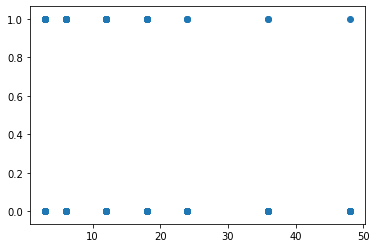

In [35]:
plt.scatter(df[["Months in Good Standing"]], df["Defaulted? (0/1 = no/yes)"])

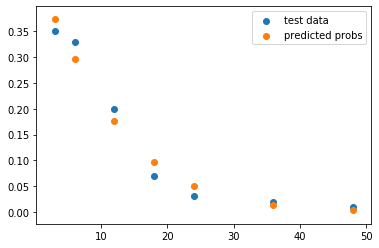

In [42]:
plt.scatter(months_in_good_standing, probabilities_by_months, label="test data")
plt.scatter(months_in_good_standing, predicted_probs[:,1], label="predicted probs")
plt.legend();